<img src='../images/hanzi_hero_icon.png' style="float: left; margin: 20px; height: 55px">

# Hanzi Hero: Empowering Kids to Master Chinese Characters
<div style="text-align: right"> <H3> By Jayme Zhang </div>

---

## Introduction to Problem Statement
While Chinese language is gaining popularity, its complex writing system presents a significant hurdle to fluency. Memorizing characters is essential for reading and pronunciation. Schools have been conducting Chinese spelling tests for students, aiming to build a strong foundation early on. However, this approach might prove challenging for Singaporean parents who juggle busy schedules and may not be proficient in Mandarin themselves.

This project aims to build an image recognition model for handwritten Chinese characters, so that we can assist students and non-Chinese learners better with their learning journey.

## Problem Statement

#### *How might we design a tool to automate the revision of Chinese spelling test for children, alleviating the current reliance on adult supervision?*

Content:
  
[01_EDA](01_EDA.ipynb)  
[02_Self_Trained_Model_Binary](02_Self_Trained_Model_Binary.ipynb)  
[03_Self_Trained_Model_Multiclass](03_Self_Trained_Model_Multiclass.ipynb)  
[04_Pre_Trained_Model_Multiclass](04_Pre_Trained_Model_Multiclass.ipynb)  
[05_SVM_Multiclass](05_SVM_Multiclass.ipynb)  
[06_Self_Trained_Model_Multiclass_HP_Tune](06_Self_Trained_Model_Multiclass_HP_Tune.ipynb)  

## 1. Exploratory Data Analysis

In [33]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from PIL import Image

### 1.1  Source of Data

Our project focuses on creating an image recognition model for handwritten Chinese characters.  
  
The data originates from the CASIA Offline database, a public resource developed by the Chinese National Laboratory of Pattern Recognition (NLPR) and the Institute of Automation of Chinese Academy of Sciences (CASIA). This dataset consists of handwritten samples contributed by 1,020 individuals between 2007 and 2010.  
  
The original custom-encoded binary files have been conveniently converted to PNG image files for ease of use in our model. Both the original files and PNG image files can be downloaded from [Kaggle](https://www.kaggle.com/datasets/pascalbliem/handwritten-chinese-character-hanzi-datasets/data).  
  
Upon downloading, save both `Test` and `Train` folders into this empty [`raw_data`](../data/raw_data/) folder, and we are good to run the notebook.
  
*This dataset from Kaggle is 14GB in size. This is the only notebook which will require the entire dataset. From the next notebook onwards, we will use extracts from this data set, and the files are uploaded in GitHub.*

### 1.2 Explore Dataset

#### 1.2.1 Directory of Dataset

This data set is split into `test` and `train` folder, with 7330 sub-folder within each folder, comprising of labeled PNG images for a comprehensive set of written characters. It encompasses all 6,763 characters from the GB2312 encoding standard, along with alphanumeric characters and symbols. Each image is conveniently grouped within a sub-folder named after the character it represents.

```
.
└── data/
    └── raw_data/
        ├── Test/
        │   ├── #
        │   ├── 2
        │   ├── C
        │   ├── 我
        │   ├── 花
        │   └── ...
        └── Test/
            ├── #
            ├── 2
            ├── C
            ├── 我
            ├── 花
            └── ...

```

#### 1.2.2 Number of Images for Test Dataset

We will explore the number of images within each sub-folder named after a character for the Test dataset.  
To facilitate this, we will define a function to compile the name of sub-folder and number of images into a dataframe for easy processing.

In [2]:
# Function to compile name of folder and number of images within into a dataframe
def count_files_in_subfolder(root_folder):
    folder_names = []
    file_counts = []

    for root, dirs, files in os.walk(root_folder):
        for directory in dirs:
            folder_path = os.path.join(root, directory)
            folder_names.append(directory)
            file_counts.append(len(os.listdir(folder_path)))

    df = pd.DataFrame({
        'Character': folder_names,
        'Number of images': file_counts
    })

    return df

In [3]:
# To tabulate number of images in test folder into a dataframe
df_test = count_files_in_subfolder('../data/raw_data/Test')

In [4]:
# First look at df_test
display(df_test)

,Character,Number of images
0,理,143
1,窆,59
2,蓼,60
3,锥,144
4,斓,60
...,...,...
7325,鸥,143
7326,伴,142
7327,缆,142
7328,;,201


In [5]:
# Summary statistics of df_test
df_test.describe()

,Number of images
count,7330.000000
mean,105.937653
std,46.035184
min,54.000000
25%,60.000000
50%,140.000000
75%,143.000000
max,404.000000


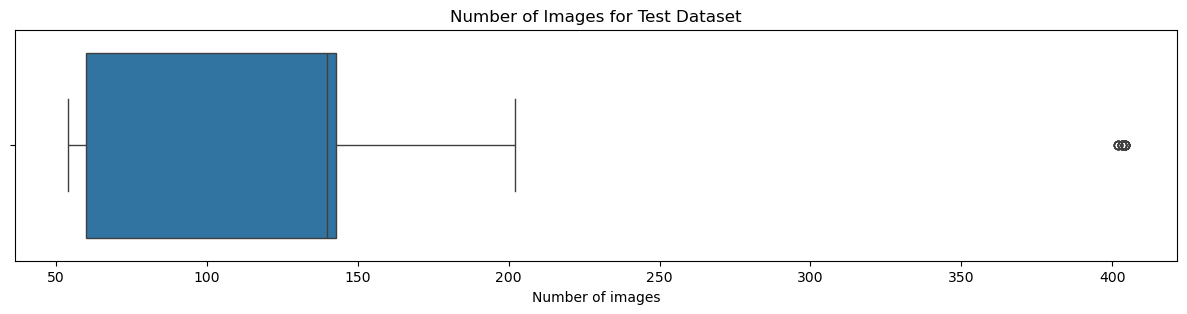

In [24]:
# Key summary statistics in the form of boxplot
plt.figure(figsize=(15,3))
sns.boxplot(df_test['Number of images'], orient='h')
plt.title('Number of Images for Test Dataset')
plt.xlabel('Number of images');

Based on the summary statistics, 50% of our sub-folders have between 60 to 143 images. In other words, the interquartile range is 83.  
However, the mean is 106 whereas the median is 140. This difference is due to the outliers with more than 400 images for several sub-folders, as seen from the above boxplot.  
We will take a further look into these outliers.

In [20]:
# To filter out rows in df_test where number of images is more than 400
df_test[df_test['Number of images']>400]

,Character,Number of images
2654,R,404
2702,U,404
2883,I,403
2933,N,402
3020,G,402
3137,Z,402
3328,T,404
3363,S,404
3439,A,403
3526,F,404


We found out these outliers are actually characters of the English alphabet.

In [22]:
# To filter out rows in df_test where number of images is between 150 and 250
df_test[(df_test['Number of images']>150) & (df_test['Number of images']<250)]

,Character,Number of images
43,⑩,201
66,△,202
116,⑧,201
121,full_stop,202
188,①,202
...,...,...
7139,5,202
7176,greater_than,201
7190,@,198
7241,℃,202


We took a closer look at the characters beyond the 75% percentile, and found out that they include numbers, punctuation and symbols.  
Since we are focusing on Chinese characters, these outliers will not affect our result.

#### 1.2.3 Number of Images for Train Dataset

We will explore the number of images within each sub-folder named after a character for the Train dataset.  
We will be using the function which we have previously defined above.

In [62]:
# To tabulate number of images in train folder into a dataframe
df_train = count_files_in_subfolder('../data/raw_data/Train')

In [63]:
# First look at df_train
display(df_train)

,Character,Number of images
0,理,597
1,窆,239
2,蓼,240
3,锥,599
4,斓,240
...,...,...
7325,鸥,598
7326,伴,602
7327,缆,597
7328,;,856


In [64]:
# Summary statistics of df_train
df_train.describe()

,Number of images
count,7330.00000
mean,439.70573
std,198.81263
min,225.00000
25%,239.00000
50%,594.00000
75%,599.00000
max,1708.00000


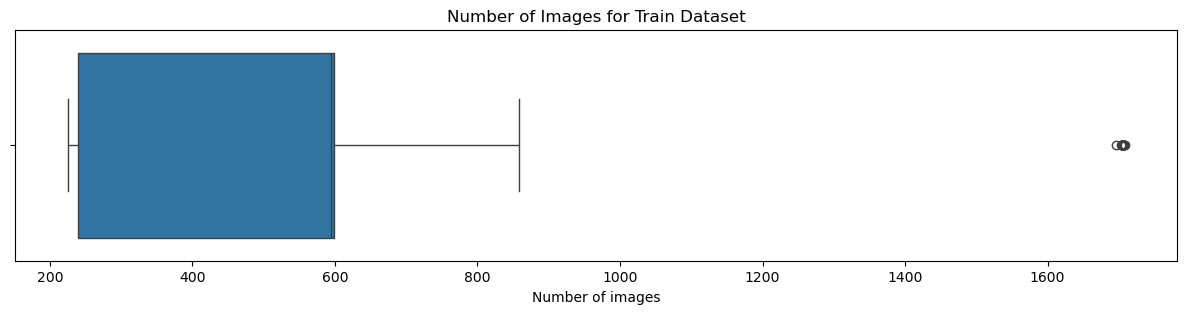

In [65]:
# Key summary statistics in the form of boxplot
plt.figure(figsize=(15,3))
sns.boxplot(df_train['Number of images'], orient='h')
plt.title('Number of Images for Train Dataset')
plt.xlabel('Number of images');

Based on the summary statistics, 50% of our sub-folders have between 239 to 599 images. In other words, the interquartile range is 360.  
However, the mean is 440 whereas the median is 594. This difference is due to the outliers with more than 1600 images for several sub-folders.  
This situation is very similar to that of the Test data in 1.2.2.  
We will take a further look into these outliers.

In [66]:
# To filter out rows in df_test where number of images is more than 1600
df_train[df_train['Number of images']>1600]

,Character,Number of images
2654,R,1704
2702,U,1706
2883,I,1706
2933,N,1706
3020,G,1705
3137,Z,1696
3328,T,1707
3363,S,1706
3439,A,1705
3526,F,1705


We found out these outliers are actually characters of the English alphabet.

In [67]:
# To filter out rows in df_test where number of images is between 650 and 1000
df_train[(df_train['Number of images']>650) & (df_test['Number of images']<1000)]

,Character,Number of images
43,⑩,842
66,△,848
116,⑧,847
121,full_stop,857
188,①,849
...,...,...
7190,@,852
7236,P,1706
7241,℃,848
7321,W,1703


We took a closer look at the characters beyond the 75% percentile, and found out that they include numbers, punctuation and symbols.  
Since we are focusing on Chinese characters, these outliers will not affect our result.

#### 1.2.4 Images of Test and Train Dataset

We will take a look at 3 random images and its attributes from the following sub-folders:  
  
1. `我` - me/ myself/ I
2. `爱` - love
3. `吃` - eat  
  
These 3 Chinese characters are all in [Level 1 word list](https://hsk.academy/en/hsk-1-vocabulary-list) of the [Chinese Proficiency Test HSK](https://en.wikipedia.org/wiki/Hanyu_Shuiping_Kaoshi), and are selected due to its frequency of usage.

In [57]:
# Function to display 3 randomly selected images and its attributes from sub-folder
def display_images(root_folder, subfolders, num_of_images):
    for subfolder in subfolders:
        folder_path = os.path.join(root_folder, subfolder)
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

        selected_files = random.sample(files, num_of_images)

        print(f"Randomly selected images and their attributes from {subfolder}:")
        for file_name in selected_files:
            file_path = os.path.join(folder_path, file_name)
            image = Image.open(file_path)
                
            # Display the image
            plt.imshow(image)
            plt.title(file_name)
            plt.axis('off')  # Turn off axis labels
            plt.show()  # Show the image

            # Display picture attributes
            print(f"\tImage: {file_path}")
            print(f"\tSize: {image.size}")
            print(f"\tFormat: {image.format}")
            print(f"\tMode: {image.mode}")
            print()  # Empty line for separation

Randomly selected images and their attributes from 我:


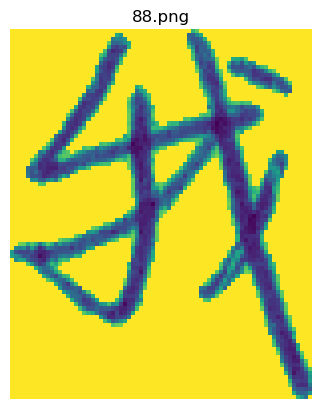

	Image: ../data/raw_data/Test/我/88.png
	Size: (75, 92)
	Format: PNG
	Mode: L



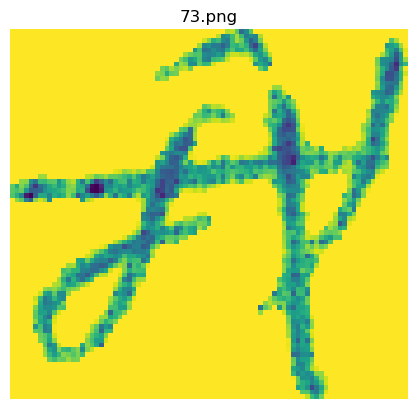

	Image: ../data/raw_data/Test/我/73.png
	Size: (85, 79)
	Format: PNG
	Mode: L



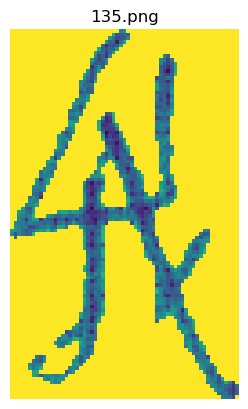

	Image: ../data/raw_data/Test/我/135.png
	Size: (63, 102)
	Format: PNG
	Mode: L

Randomly selected images and their attributes from 爱:


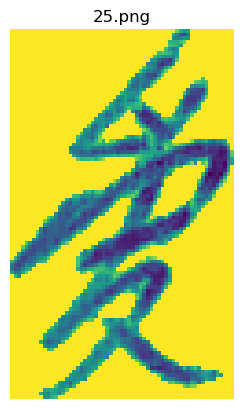

	Image: ../data/raw_data/Test/爱/25.png
	Size: (61, 101)
	Format: PNG
	Mode: L



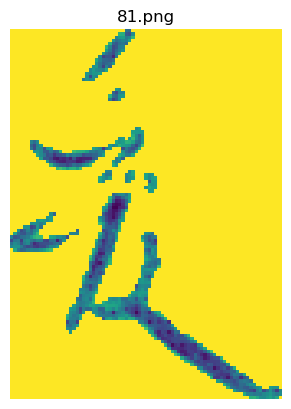

	Image: ../data/raw_data/Test/爱/81.png
	Size: (83, 113)
	Format: PNG
	Mode: L



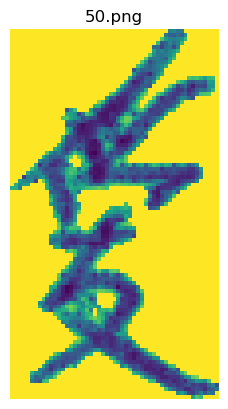

	Image: ../data/raw_data/Test/爱/50.png
	Size: (53, 94)
	Format: PNG
	Mode: L

Randomly selected images and their attributes from 吃:


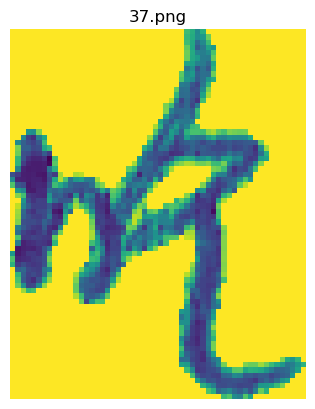

	Image: ../data/raw_data/Test/吃/37.png
	Size: (56, 70)
	Format: PNG
	Mode: L



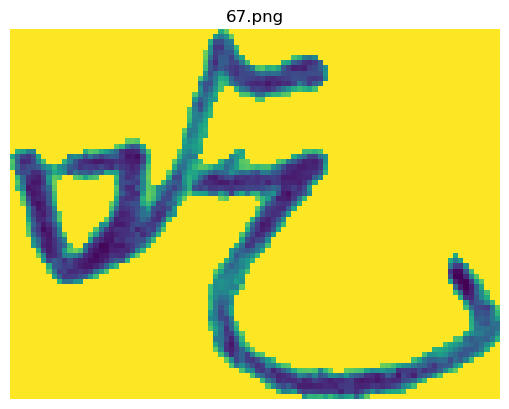

	Image: ../data/raw_data/Test/吃/67.png
	Size: (94, 71)
	Format: PNG
	Mode: L



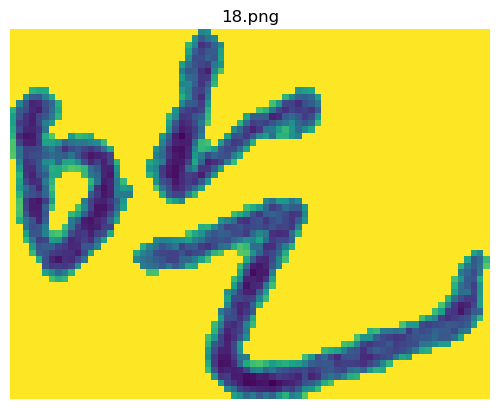

	Image: ../data/raw_data/Test/吃/18.png
	Size: (74, 57)
	Format: PNG
	Mode: L



In [60]:
# To display 3 randomly selected images from '我', '爱', '吃' sub-folders from test dataset
root_folder = '../data/raw_data/Test'
subfolders = ['我', '爱', '吃']
num_of_images = 3
display_images(root_folder, subfolders, num_of_images)

Randomly selected images and their attributes from 我:


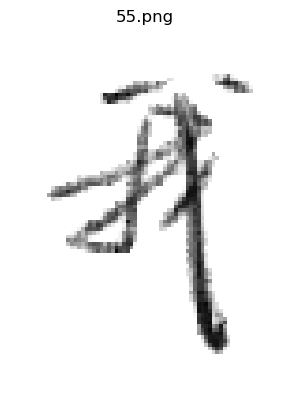

	Image: ../data/raw_data/Train/我/55.png
	Size: (72, 99)
	Format: PNG
	Mode: RGBA



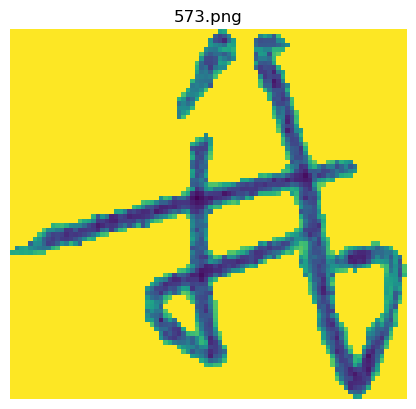

	Image: ../data/raw_data/Train/我/573.png
	Size: (88, 82)
	Format: PNG
	Mode: L



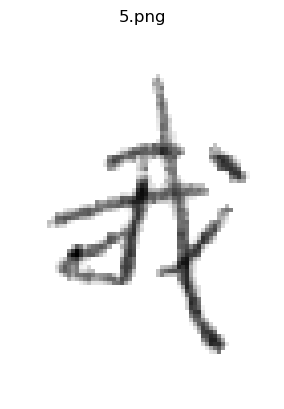

	Image: ../data/raw_data/Train/我/5.png
	Size: (65, 91)
	Format: PNG
	Mode: RGBA

Randomly selected images and their attributes from 爱:


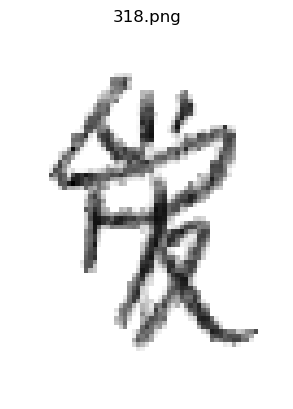

	Image: ../data/raw_data/Train/爱/318.png
	Size: (63, 85)
	Format: PNG
	Mode: RGBA



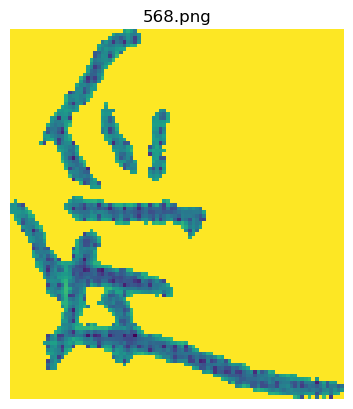

	Image: ../data/raw_data/Train/爱/568.png
	Size: (92, 102)
	Format: PNG
	Mode: L



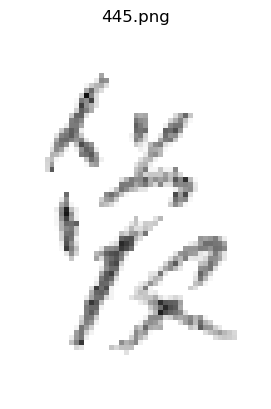

	Image: ../data/raw_data/Train/爱/445.png
	Size: (51, 75)
	Format: PNG
	Mode: RGBA

Randomly selected images and their attributes from 吃:


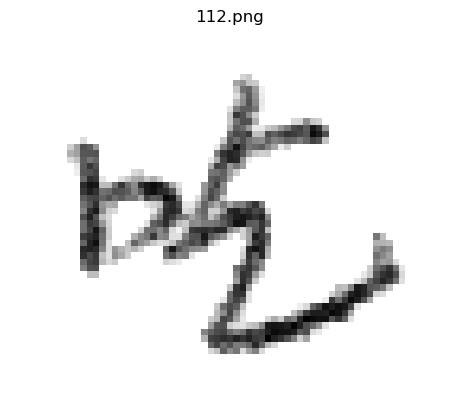

	Image: ../data/raw_data/Train/吃/112.png
	Size: (69, 58)
	Format: PNG
	Mode: RGBA



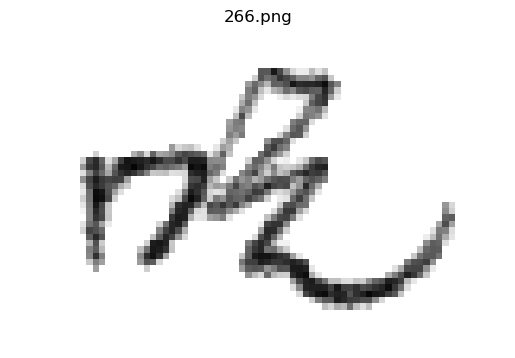

	Image: ../data/raw_data/Train/吃/266.png
	Size: (78, 50)
	Format: PNG
	Mode: RGBA



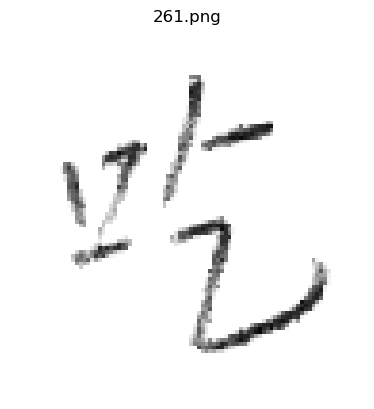

	Image: ../data/raw_data/Train/吃/261.png
	Size: (93, 97)
	Format: PNG
	Mode: RGBA



In [61]:
# To display 3 randomly selected images from '我', '爱', '吃' sub-folders from train dataset
root_folder = '../data/raw_data/Train'
subfolders = ['我', '爱', '吃']
num_of_images = 3
display_images(root_folder, subfolders, num_of_images)

We can make a few observations on the images from both test and train datasets:  
  
- There are differences in terms of the handwriting style, whether it is being printed or cursive, upright or slanted left or right
- The size of images are varied
- All images are in PNG format
- A mixture of images in different modes: RGBA (4x8-bit pixels, true color with transparency mask) and L (8-bit pixels, grayscale)  
  
These observations will give us directions on the pre-processing steps required for the images before using them for training.

### 1.3 Summary of Dataset

Based on the above analysis performed on our dataset, we have a median of 140 and 594 images from the `test` and `train` folders respectively.   
  
As for the images within the sub-folders, we will be doing some pre-processing steps before feeding them into the model.  
  
We will explore these steps in greater details from the next notebook [02_Self_Trained_Model_Binary](02_Self_Trained_Model_Binary.ipynb) onwards.  